In [1]:
#Import
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras import layers
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical   
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

import re
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize



In [9]:
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
additional  = ['rt','rts','retweet'] # lista adicional de stopwords
swords = set().union(stopwords.words('english'),additional) # adicionando palavras para o stopwords

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bhla\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhla\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [10]:
path = "dataset_sidi_v1.2.csv"
path512 = "dataset_sidi_512.csv"

df512 = pd.read_csv(path512, sep='\t')
df512

,Unnamed: 0,Unnamed: 0.1,image_name,NEG,NEU,POS,text,sent_text,sent_image,image_path,image_height,image_width
0,382583,382583,798338609870872577-2,0.774375,0.174701,0.050924,what does it look like i do for a living? (cra...,NEG,0,data/79833/798338609870872577-2.jpg,1280,722
1,443004,443004,802556641057054721-1,0.540009,0.304103,0.155888,No cheat just skill. #ClikerHeroes https://t.c...,NEG,0,data/80255/802556641057054721-1.jpg,707,1366
2,348885,348885,796032212407721984-1,0.513661,0.322456,0.163883,@KEILOin_DaTrunk I deleted https://t.co/qIhBkn...,NEG,0,data/79603/796032212407721984-1.jpg,1334,750
3,377487,377487,798011160532381696-1,0.712648,0.254173,0.033180,"""RT NYTFashion: How Nasty Gal went from an eBa...",NEG,0,data/79801/798011160532381696-1.jpg,561,1000
4,423703,423703,801181521679790080-1,0.713677,0.186854,0.099468,I hate this nigga lmaooo https://t.co/gPcyJfJESN,NEG,0,data/80118/801181521679790080-1.jpg,1334,750
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,108284,108284,769551952275509248-1,0.010517,0.886504,0.102978,RT @Alwas97: find someone who loves you like b...,NEU,1,data/76955/769551952275509248-1.jpg,1218,1078
11996,93186,93186,769486781158858753-1,0.065240,0.897818,0.036942,RT @MelbWritersFest: Helen Garner talking to @...,NEU,1,data/76948/769486781158858753-1.jpg,1491,2048
11997,298145,298145,783915769943973890-1,0.011468,0.925276,0.063257,Watch lesbian movie: https://t.co/jzJrDcnAwaSh...,NEU,1,data/78391/783915769943973890-1.jpg,1024,683
11998,260672,260672,783138720610476033-1,0.003072,0.957911,0.039016,Click here to watch the movie: https://t.co/A...,NEU,1,data/78313/783138720610476033-1.jpg,1024,682


In [11]:
#tokenização
t  = Tokenizer()

filenames = df512['text'].tolist()
t.fit_on_texts(filenames)


labels = df512['sent_image'].tolist()

#holdout 80/10/10
#Separando treino e parte para validação e teste
x_train, x_split_two, y_train, y_split_two = train_test_split( filenames,labels, train_size=0.8,random_state=42)
#Separando teste e validação
x_val, x_test, y_val, y_test = train_test_split(x_split_two,y_split_two, train_size=0.5,random_state=42)

In [12]:
x_train = t.texts_to_sequences(x_train)
x_val = t.texts_to_sequences(x_val)
x_test_VADER = x_test
x_test = t.texts_to_sequences(x_test)

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def tweet_to_VADER_sentiment(tweet):

    sid_obj = SentimentIntensityAnalyzer()
    
    text = re.sub("@[A-Za-z0-9_]+","", tweet) #remove menções
    text = re.sub("#[A-Za-z0-9_]+","", text)  # remove hashtag
   
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) 
    words = word_tokenize(text)
    
    words = [w for w in words if w not in stopwords.words("english")]

    sentiment_dict = sid_obj.polarity_scores(tweet)

        # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        return 2
 
    elif sentiment_dict['compound'] <= - 0.05 :
        return  0
 
    else :
        return 1

In [15]:
y_pred = [tweet_to_VADER_sentiment(i) for i in x_test_VADER]
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred));


0.7091666666666666
              precision    recall  f1-score   support

           0       0.86      0.60      0.70       420
           1       0.73      0.60      0.65       374
           2       0.63      0.93      0.75       406

    accuracy                           0.71      1200
   macro avg       0.74      0.71      0.70      1200
weighted avg       0.74      0.71      0.70      1200



Negativo - 0     Neutro - 1      Positivo - 2


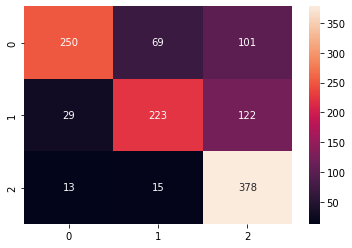

In [25]:
print("Negativo - 0     Neutro - 1      Positivo - 2")
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d");

In [23]:
matrix = confusion_matrix(y_test,y_pred)
print("Negativo     Neutro     Positivo")
print(matrix.diagonal()/matrix.sum(axis=1))


Negativo     Neutro     Positivo
[0.5952381  0.59625668 0.93103448]
